## Summary


In [112]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import xgboost as xgb
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor


In [89]:
# Load train dataset
train = pd.read_csv("../../data/train.csv")
train.head(1)


,num_of_photos,num_of_patio_and_porch_features,num_of_security_features,num_of_window_features,living_area_sq_ft,avg_school_rating,num_of_bathrooms,num_of_bedrooms,num_of_stories,age,airport_distance,city,home_type,latest_price
0,39,1,3,1,2601.0,2.666667,3.0,4,2,11,16.06,pflugerville,Single Family,305000.0


In [90]:
train["avg_school_rating"] = (
    train["avg_school_rating"].map("{:,.2f}".format).astype("float32")
)


In [91]:
# Check dataset shape
train.shape


(11658, 14)

In [129]:
X = train.drop(
    columns=[
        "latest_price",
        "num_of_patio_and_porch_features",
        "num_of_security_features",
        "num_of_window_features",
    ]
)
X = pd.get_dummies(
    data=X,
    columns=[
        "home_type",
        "city",
    ],
)
y = train["latest_price"]
y = np.log(y)


In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, train_size=0.8
)


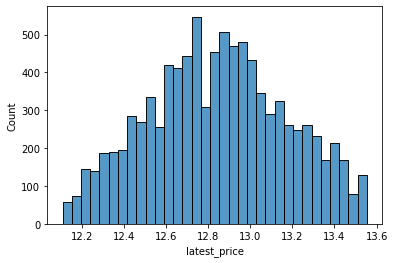

In [131]:
sns.histplot(y_train)


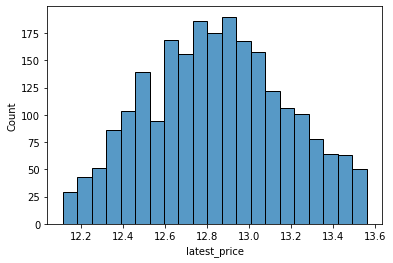

In [132]:
sns.histplot(y_test)


In [133]:
lr = LinearRegression()
# Fit train data
lr.fit(X_train, y_train)
print(
    "Train score : \t",
    lr.score(X_train, y_train),
    "\tTrain RMSE : \t",
    mean_squared_error(np.exp(y_train), np.exp(lr.predict(X_train)), squared=False),
)
print(
    "Test score : \t",
    lr.score(X_test, y_test),
    "\tTest RMSE : \t",
    mean_squared_error(np.exp(y_test), np.exp(lr.predict(X_test)), squared=False),
)
print("cross_val_score :", cross_val_score(lr, X, y, cv=5).mean())


Train score : 	 0.4265245812253621 	Train RMSE : 	 102070.5238823991
Test score : 	 0.438791591453246 	Test RMSE : 	 101046.27630089618
cross_val_score : 0.34309282038892197


Text(0, 0.5, 'Predicted SalePrice')

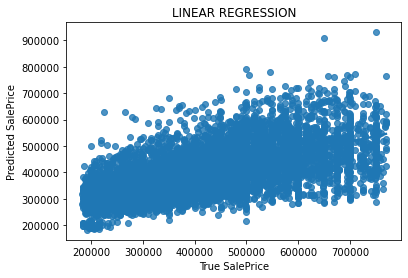

In [134]:
sns.regplot(x=np.exp(y_train), y=np.exp(lr.predict(X_train)))
plt.title("LINEAR REGRESSION")
plt.xlabel("True SalePrice")
plt.ylabel("Predicted SalePrice")


Text(0, 0.5, 'Residuals')

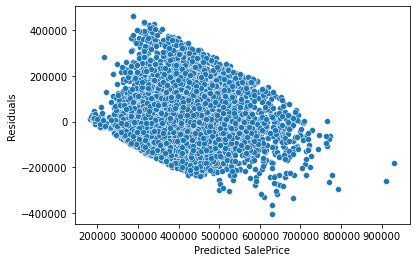

In [135]:
# Plot residuals
y_train_preds = np.exp(lr.predict(X_train))
residuals = np.exp(y_train) - y_train_preds
sns.scatterplot(x=y_train_preds, y=residuals)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")


## RidgeCV


In [136]:
alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)
ridge_cv.alpha_, ridge_cv.best_score_


(1.0, 0.42253059437365625)

In [137]:
print(
    f"Training Score: {ridge_cv.score(X_train, y_train)}",
    "\tMSE : \t",
    mean_squared_error(
        np.exp(y_train), np.exp(ridge_cv.predict(X_train)), squared=False
    ),
)
print(
    f"Testing Score: {ridge_cv.score(X_test, y_test)}",
    "\tMSE : \t",
    mean_squared_error(np.exp(y_test), np.exp(ridge_cv.predict(X_test)), squared=False),
)
print("cross_val_score :", cross_val_score(ridge_cv, X, y, cv=5).mean())


Training Score: 0.4263599952511712 	MSE : 	 102085.2903078953
Testing Score: 0.43930994859405925 	MSE : 	 101017.73270691298
cross_val_score : 0.3425360823015098


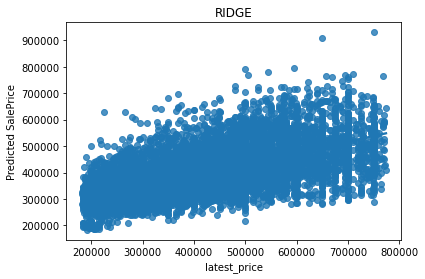

In [138]:
sns.regplot(x=np.exp(y), y=np.exp(ridge_cv.predict(X)))
plt.title("RIDGE")
plt.ylabel("Predicted SalePrice")


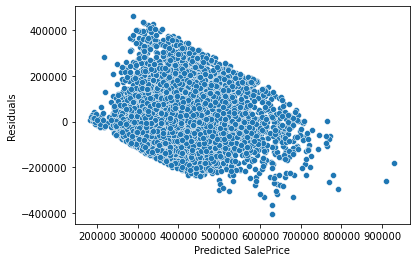

In [139]:
# Plot residuals
y_train_preds = np.exp(ridge_cv.predict(X_train))
residuals = np.exp(y_train) - y_train_preds
sns.scatterplot(x=y_train_preds, y=residuals)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")


## Lasso


In [140]:
l_alphas = np.logspace(-3, 0, 100)
lasso_cv = LassoCV(alphas=l_alphas, tol=0.05)  # increase tol=0.05 to prevent warning
lasso_cv.fit(X_train, y_train)
print(
    "Train score : \t",
    lasso_cv.score(X_train, y_train),
    "\tRMSE : \t",
    mean_squared_error(
        np.exp(y_train), np.exp(lasso_cv.predict(X_train)), squared=False
    ),
)
print(
    "Test score : \t",
    lasso_cv.score(X_test, y_test),
    "\tRMSE : \t",
    mean_squared_error(np.exp(y_test), np.exp(lasso_cv.predict(X_test)), squared=False),
)
print("cross_val_score :", cross_val_score(lasso_cv, X, y, cv=5).mean())


Train score : 	 0.4225516982551554 	RMSE : 	 102367.69262869096
Test score : 	 0.4364639590565069 	RMSE : 	 101124.7133754567
cross_val_score : 0.34096568927764465


Text(0, 0.5, 'Predicted SalePrice')

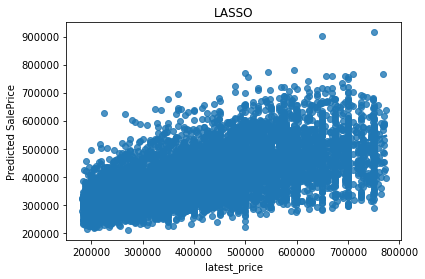

In [141]:
sns.regplot(x=np.exp(y), y=np.exp(lasso_cv.predict(X)))
plt.title("LASSO")
plt.ylabel("Predicted SalePrice")


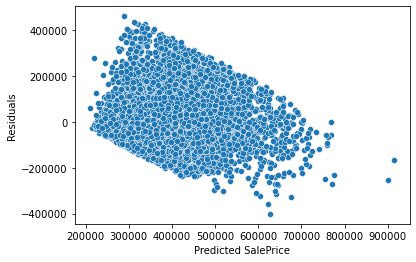

In [142]:
# Plot residuals
y_train_preds = np.exp(lasso_cv.predict(X_train))
residuals = np.exp(y_train) - y_train_preds
sns.scatterplot(x=y_train_preds, y=residuals)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")


## XGBoost


In [143]:
regressor = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    colsample_bytree=0.7,
    objective="reg:squarederror",
)

regressor.fit(X_train, y_train)

print(
    "Train score : \t",
    regressor.score(X_train, y_train),
    "\tRMSE : \t$",
    mean_squared_error(
        np.exp(y_train), np.exp(regressor.predict(X_train)), squared=False
    ),
)
print(
    "Test score : \t",
    regressor.score(X_test, y_test),
    "\tRMSE : \t$",
    mean_squared_error(
        np.exp(y_test), np.exp(regressor.predict(X_test)), squared=False
    ),
)
print("cross_val_score :", cross_val_score(regressor, X, y, cv=5).mean())


Train score : 	 0.6901388771454987 	RMSE : 	$ 74634.52458987312
Test score : 	 0.6125457743665395 	RMSE : 	$ 83789.6132878382
cross_val_score : 0.39998021531337546


In [144]:
params = {
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "colsample_bytree": [0.3, 0.7],
}

xgbr = xgb.XGBRegressor(seed=20)
clf = GridSearchCV(
    estimator=xgbr, param_grid=params, scoring="neg_mean_squared_error", verbose=1
)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_) ** (1 / 2.0))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
Lowest RMSE:  0.245201626545154


In [145]:
params = {
    "max_depth": [3, 6, 10],
    "ccp_alpha": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
}

rfr = RandomForestRegressor()
rfr_grid = GridSearchCV(
    estimator=rfr,
    param_grid=params,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1,
)
rfr_grid.fit(X, y)
print("Best parameters:", rfr_grid.best_params_)
print("Lowest RMSE: ", (-rfr_grid.best_score_) ** (1 / 2.0))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'ccp_alpha': 0.01, 'max_depth': 3, 'n_estimators': 100}
Lowest RMSE:  0.2965578892785415


In [146]:
# Create the model
level_1_estimators = [
    ("lasso", LassoCV()),
    ("bag", rfr_grid.best_estimator_),
    ("xgb_clf", clf.best_estimator_),
]

stacked_model = StackingRegressor(
    estimators=level_1_estimators, final_estimator=LinearRegression()
)


In [147]:
# Cross-val score
cross_val_score(stacked_model, X_train, y_train).mean()


0.6327597657072245

In [148]:
# Fit
stacked_model.fit(X_train, y_train)


StackingRegressor(estimators=[('lasso', LassoCV()),
                              ('bag',
                               RandomForestRegressor(ccp_alpha=0.01,
                                                     max_depth=3)),
                              ('xgb_clf',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=No...
                                            importance_typ

In [149]:
# Train score
stacked_model.score(X_train, y_train)


0.7298710499783343

In [150]:
# Test score
stacked_model.score(X_test, y_test)


0.6312172258360942

Text(0, 0.5, 'Predicted SalePrice')

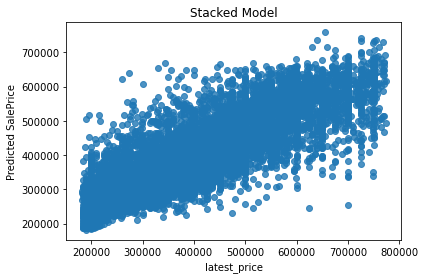

In [151]:
sns.regplot(x=np.exp(y), y=np.exp(stacked_model.predict(X)))
plt.title("Stacked Model")
plt.ylabel("Predicted SalePrice")


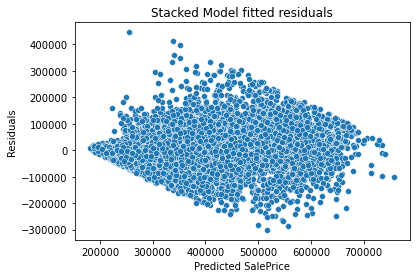

In [152]:
# Plot residuals
y_train_preds = np.exp(stacked_model.predict(X_train))
residuals = np.exp(y_train) - y_train_preds
plt.title("Stacked Model fitted residuals")
sns.scatterplot(x=y_train_preds, y=residuals)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")


---

Save model


In [108]:
file_name = "../../models/xgb_reg.pkl"

# save xgboost
pickle.dump(regressor, open(file_name, "wb"))


In [153]:
file_name = "../../models/stacked_reg.pkl"

# save stacked
pickle.dump(stacked_model, open(file_name, "wb"))


In [157]:
X.shape


(11658, 23)